# interpolate time dependent llc variable along trajectories

Right now there are lots of gaps as a diagnostic computed on one tile

Zoé to do (maybe):

- rechunk such as it looks more like snapshots
- add other variables (sea level, sst, sss, wind)


In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import pyinterp
import pyinterp.backends.xarray

import mitequinox.plot as pl
import mitequinox.utils as ut
#import mitequinox.parcels as pa
from mitequinox.parcels import store_parquet

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.6189691.datarmor0/parcels-55081/libparcels_random_579d8d47-d9d8-4c47-855c-49fdfdf4546a.so


In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=4, cores=4)
    #w = cluster.scale(jobs=15) # heavier data processing
    #w = cluster.scale(jobs=10)
    w = cluster.scale(jobs=3)
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    #cluster = LocalCluster(n_workers=2, threads_per_worker=1)
    cluster = LocalCluster()
    client = Client(cluster)
    client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


In [3]:
#print(cluster.job_script())

---

## load data

In [4]:
site = "california"
site_dir = os.path.join(ut.diag_dir, "regional_"+site)

In [4]:
#ds = xr.open_zarr(os.path.join(site_dir, "llc.zarr") )
df = dd.read_parquet(os.path.join(site_dir, "llc_parcels_time_mean"))
df = df.repartition(npartitions=500).persist()

---

## interpolate new diagnostic along drifter tracks

ds is not properly chunked at the moment

In [7]:
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,sea_level_mean,zonal_velocity_mean,temperature_mean,meridional_velocity_mean,salinity_mean
time,,,,,,,,,,,,,,
2011-11-15,38000612,43.223770,-152.822922,0.0,0.0,0.0,0.0,0.0,0.0,0.301963,0.111188,11.264963,-0.047701,32.847267
2011-11-15,38000637,43.223770,-151.781250,0.0,0.0,0.0,0.0,0.0,0.0,0.289056,0.094942,11.465209,0.017127,32.781781
2011-11-15,38000661,42.514122,-150.739578,0.0,0.0,0.0,0.0,0.0,0.0,0.323792,0.107724,12.161278,-0.024647,32.890323
2011-11-15,38000685,41.797028,-149.697922,0.0,0.0,0.0,0.0,0.0,0.0,0.352433,0.089004,13.222504,-0.016940,33.018796
2011-11-15,38000692,46.660358,-149.697922,0.0,0.0,0.0,0.0,0.0,0.0,0.242264,0.074070,8.888128,0.006434,32.550297


In [8]:
def interp(df):

    if hasattr(df, "time"):
        t = df["time"].unique()[0]
    elif df.index.name == "time":
        # dask dataframe
        t = df.index.unique()[0]
    elif hasattr(df, "name"):
        # when mapped after groupby
        t = df.name
    else:
        assert False, "Cannot find float id"

    diag = load_instantaneous_diagnostic(t)

    # interpolate on tracks
    for v in diag:
        df[v] = interp_snapshot(diag[v], df)

    return df
    

def load_instantaneous_diagnostic(t):
    
    # overwrite default with threaded scheduler    
    # "single-threaded"
    import dask
    
    with dask.config.set(scheduler="single-threaded"):

        # load data
        # not properly chunked
        #ds = xr.open_zarr(os.path.join(site_dir, "llc.zarr") )
        #ds = xr.open_zarr(os.path.join(ut.ref_data_dir, "SSU.zarr") ).rename({"i_g": "i"})
        #ds = ds.sel(face=10)
        #grd = (xr.open_zarr(os.path.join(ut.ref_data_dir, "grid.zarr") )[["XC", "YC"]]
        #       .sel(face=10)
        #       .rename({"XC": "lon", "YC": "lat"})
        #      )
        #ds = xr.merge([ds, grd])
        #ds = ds.sel(time=t, method="nearest")
        
        #diag_dir = '/home/datawork-lops-osi/equinox/mit4320/diags/'
        ds = xr.merge([(xr.open_zarr(os.path.join(ut.diag_dir,"dEta_"+_dir+"_california.zarr"))
                        .sel(time=t, method="nearest")
                        .rename({"dEta_"+_dir+"_california": "dEta_"+_dir})
                        .rename({"XC": "lon", "YC": "lat"})
                       )
                       for _dir in ["dx", "dy"]]
                     )
        
        # build diagnostic
        #diag = 0.5*(ds["meridional_velocity"]**2+ds["zonal_velocity"]**2)        
        #diag = ds["SSU"].compute()
        diag = ds.compute()
         
    return diag

def interp_snapshot(da, df):

    # prepare interpolator
    mesh = pyinterp.RTree()
    lons = da.lon
    lats = da.lat
    mesh.packing(
        np.vstack((lons.values.flatten(), lats.values.flatten())).T,
        da.values.flatten(),
    )

    # target positions
    lon = df["lon"].values
    lat = df["lat"].values

    out, neighbors = mesh.inverse_distance_weighting(
        np.vstack((lon, lat)).T,
        within=True,  # Extrapolation is forbidden
        radius=55000,  # In a radius of 5.5 Km
        k=8,  # We are looking for at most 8 neighbours
        num_threads=0,
    )
    
    return out

In [9]:
#_df = df.get_partition(0).compute().iloc[:1000, :]
#_df = df.get_partition(0)
_df = df

out = _df.groupby(_df.index).apply(interp).persist()

/dev/shm/pbs.5932834.datarmor0/ipykernel_55645/3337645608.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  out = _df.groupby(_df.index).apply(interp).persist()


In [10]:
out.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,sea_level_mean,zonal_velocity_mean,temperature_mean,meridional_velocity_mean,salinity_mean,dEta_dx,dEta_dy
time,,,,,,,,,,,,,,,,
2011-11-15 02:00:00,38000612,43.218834,-152.801402,0.0,0.246942,-0.091385,0.194598,11.341290,32.743732,0.301908,0.111860,11.275245,-0.046867,32.846305,NaN,NaN
2011-11-15 02:00:00,38000637,43.222802,-151.779637,0.0,0.009288,-0.030367,0.110377,11.187393,32.752048,0.289113,0.095251,11.465579,0.017118,32.782088,NaN,NaN
2011-11-15 02:00:00,38000661,42.512788,-150.719480,0.0,0.232364,-0.015548,0.086395,11.671886,32.792000,0.323762,0.107019,12.162857,-0.024284,32.890155,NaN,NaN
2011-11-15 02:00:00,38000685,41.795849,-149.693961,0.0,0.039706,-0.012884,0.076363,12.651238,33.008923,0.352460,0.089060,13.224021,-0.016837,33.018938,NaN,NaN
2011-11-15 02:00:00,38000692,46.658046,-149.698476,0.0,-0.009903,-0.026407,-0.008411,9.259451,32.548817,0.242278,0.074139,8.890303,0.006240,32.550432,NaN,NaN


In [15]:
store_parquet(site_dir, out, name="llc_parcels_time_mean_gradp", overwrite=True)

No reindexing
deleting existing archive: /home/datawork-lops-osi/equinox/mit4320/diags/california_parcels_time_mean_gradp
create new archive: /home/datawork-lops-osi/equinox/mit4320/diags/california_parcels_time_mean_gradp


'/home/datawork-lops-osi/equinox/mit4320/diags/california_parcels_time_mean_gradp'

--- 
## Reload and make a simple comparison

In [5]:
df = dd.read_parquet(os.path.join(site_dir, "llc_parcels_time_mean_gradp"))

if False:
    # end of time series is bad for meridional velocities, don't know why
    def mask_end(df):
        #assert False, str(df.index[-1])+" {} ".format(type(df.index[-1]))
        #return df.where( df.reset_index().time < (df.index[-1]-pd.Timedelta("5D")) ) # slow
        #return df[ df.index < (df.index[-1]-pd.Timedelta("30D")) ] # slow
        df = df.reset_index().sort_values("time")
        df = df.iloc[:-24*60]
        #df = df.iloc[:10]
        return df

    df = df.groupby(df.trajectory).apply(mask_end) #.persist()
    df = df.drop(columns="trajectory").reset_index().set_index("time")

In [6]:
df = df.compute()
df = df.dropna()

# add geostrophic estimate
g=9.81
g=1  # tmp !!!
df["f"] = ut.coriolis(df["lat"])
df["zonal_velocity_geo"] = -g*df["dEta_dy"]/df["f"]
df["meridional_velocity_geo"] = g*df["dEta_dx"]/df["f"]

<AxesSubplot:xlabel='time'>

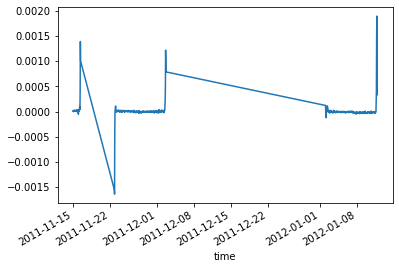

In [7]:
df.groupby("trajectory").get_group(37001242)["dEta_dx"].plot()

<AxesSubplot:xlabel='time'>

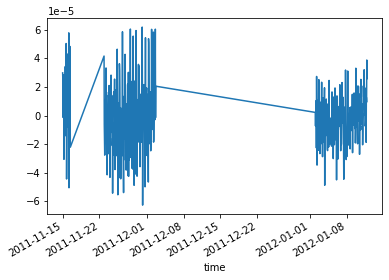

In [8]:
df.groupby("trajectory").get_group(37001242)["dEta_dy"].plot()

In [9]:
ds = (xr.open_zarr(os.path.join(site_dir, "llc.zarr") )
      .sel(time="2012-03-01 00:00:00")
      .set_coords(["lon", "lat"])
     ).persist()
ds

<xarray.Dataset>
Dimensions:              (i: 636, j: 480)
Coordinates:
    Depth                (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    face                 int64 ...
  * i                    (i) int64 2765 2766 2767 2768 ... 3397 3398 3399 3400
  * j                    (j) int64 0 1 2 3 4 5 6 ... 473 474 475 476 477 478 479
    lat                  (j, i) float64 dask.array<chunksize=(128, 128), meta=np.ndarray>
    lon                  (j, i) float64 dask.array<chunksize=(128, 128), meta=np.ndarray>
    niter                int64 dask.array<chunksize=(), meta=np.ndarray>
    time                 datetime64[ns] 2012-03-01
Data variables:
    meridional_velocity  (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    zonal_velocity       (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>

### select a couple of drifter tracks and plot time series

In [10]:
bbox = [-126, -125, 35, 36]
_df = df[ (df["lon"]>bbox[0]) & (df["lon"]<bbox[1]) & (df["lat"]>bbox[2]) & (df["lat"]<bbox[3]) ]
traj = _df["trajectory"].unique()
df_box = df[ df["trajectory"].isin(traj) ]
df_box.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,sea_level_mean,zonal_velocity_mean,temperature_mean,meridional_velocity_mean,salinity_mean,dEta_dx,dEta_dy,f,zonal_velocity_geo,meridional_velocity_geo
time,,,,,,,,,,,,,,,,,,,
2011-11-15 02:00:00,38001180,42.515934,-127.835240,0.0,-0.163039,0.036566,-0.820190,13.054238,32.503811,0.266892,0.043187,12.336187,-0.111018,32.493393,2.459938e-06,0.000015,0.000099,-0.149062,0.024959
2011-11-15 02:00:00,38001183,44.619940,-127.831165,0.0,-0.090395,-0.031511,-0.888931,12.961463,32.329632,0.268946,0.003329,12.081378,-0.069385,32.380809,-2.409666e-07,0.000006,0.000102,-0.063211,-0.002352
2011-11-15 02:00:00,38001193,41.793599,-126.784626,0.0,-0.008531,-0.041279,-0.949537,13.130943,32.419361,0.231264,-0.028080,12.037550,-0.071487,32.612068,-1.135472e-05,0.000013,0.000097,-0.132375,-0.116822
2011-11-15 02:00:00,38001198,45.294904,-126.773452,0.0,0.071825,-0.235381,-1.002509,12.574794,32.364609,0.284177,-0.000494,11.859924,-0.089372,32.337966,-2.288996e-05,-0.000031,0.000104,0.301789,-0.220827
2011-11-15 02:00:00,38001205,41.787972,-125.754117,0.0,-0.185418,-0.139409,-0.995758,13.531406,32.634354,0.196397,-0.044969,11.770530,-0.061242,32.856149,1.943999e-07,0.000004,0.000097,-0.043379,0.002000


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

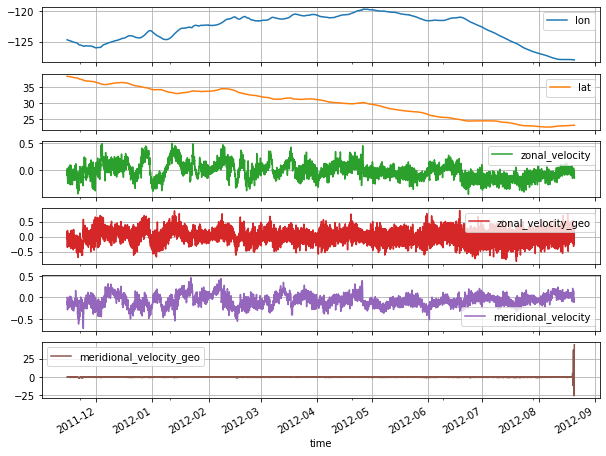

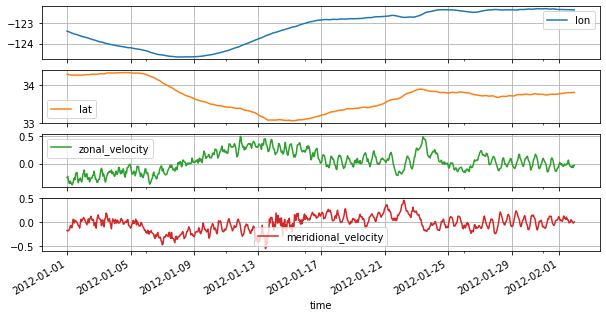

In [13]:
_df = df_box[ df_box.trajectory==traj[2] ].sort_index().drop_duplicates()
_df[["lon", "lat", "zonal_velocity", "zonal_velocity_geo","meridional_velocity", "meridional_velocity_geo"]].plot(subplots=True, grid=True, figsize=(10,8))

_df = _df.loc["2012-01-01":"2012-02-01"]
_df[["lon", "lat", "zonal_velocity", "meridional_velocity"]].plot(subplots=True, grid=True, figsize=(10,5))

Focus on geostrophy

In [24]:
_df["zonal_velocity"]

time
2012-01-01 00:00:00   -0.254389
2012-01-01 01:00:00   -0.235418
2012-01-01 02:00:00   -0.295550
2012-01-01 03:00:00   -0.357464
2012-01-01 04:00:00   -0.368514
                         ...   
2012-01-05 19:00:00   -0.258384
2012-01-05 20:00:00   -0.216940
2012-01-05 21:00:00   -0.167614
2012-01-05 22:00:00   -0.099149
2012-01-05 23:00:00   -0.098178
Name: zonal_velocity, Length: 122, dtype: float64

In [25]:
(-0.235418 + 0.254389)/3600

5.269722222222219e-06

In [28]:
( -0.295550 + 0.254389)/3600/2

-5.716805555555556e-06

In [22]:
np.gradient(_df["zonal_velocity"])/dt

array([ 5.26964060e-06, -5.71677172e-06, -1.69508144e-05, -1.01339508e-05,
        4.67909253e-06,  1.76810573e-06, -7.52213410e-06, -4.73193921e-06,
        3.68100888e-06,  1.36339918e-05,  1.14489861e-05, -9.57393058e-07,
        1.23143834e-05,  1.63059937e-05,  2.05496866e-06, -1.24991172e-05,
       -2.59303232e-05, -3.15433840e-06,  6.51053889e-06,  3.90495177e-06,
        1.06776168e-06, -9.97738924e-06,  2.34440481e-07,  2.00421162e-05,
        1.65138010e-05,  1.04787852e-05, -8.46318652e-06, -1.77261159e-05,
        5.77178893e-06,  8.17826792e-06, -1.29649902e-05, -1.42648618e-05,
        4.68372729e-06, -6.71860455e-06, -6.76246053e-06,  9.13800703e-06,
        6.57618543e-06,  1.27026602e-06,  5.93091118e-06,  7.01296355e-06,
        9.98605955e-06, -1.93231402e-06, -1.99628190e-05, -8.27199268e-06,
       -7.74550461e-06, -8.49995585e-06,  4.45425713e-06,  8.20231833e-06,
        3.03586031e-06, -1.49326943e-07,  2.29276227e-05,  2.27376082e-05,
        1.65984179e-05, -

In [21]:
dt = np.gradient( (_df.index.to_series() - pd.Timestamp("2000") )/pd.Timedelta("1s") )

_df["zonal_acceleration"] = np.gradient(_df["zonal_velocity"])/dt
_df["meridional_acceleration"] = np.gradient(_df["meridional_velocity"])/dt

_df["zonal_geo_acc"] = _df["zonal_velocity_geo"]-_df["meridional_acceleration"]/_df["f"]
_df["meridional_geo_acc"] = _df["meridional_velocity_geo"]+_df["zonal_acceleration"]/_df["f"]

_df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,sea_level_mean,...,salinity_mean,dEta_dx,dEta_dy,f,zonal_velocity_geo,meridional_velocity_geo,zonal_acceleration,meridional_acceleration,zonal_geo_acc,meridional_geo_acc
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,37001319,34.286722,-123.387298,0.0,-0.254389,-0.170485,0.033185,13.394321,33.205341,0.323159,...,33.218306,-0.000003,0.000031,0.000082,-0.376500,-0.032613,0.000005,-3.034112e-06,-0.339570,0.031527
2012-01-01 01:00:00,37001319,34.281102,-123.397704,0.0,-0.235418,-0.181408,-0.142800,13.391294,33.203499,0.323900,...,33.218238,0.000029,0.000030,0.000082,-0.371220,0.355463,-0.000006,3.627770e-07,-0.375636,0.285871
2012-01-01 02:00:00,37001319,34.275804,-123.410677,0.0,-0.295550,-0.167873,-0.275945,13.374022,33.208282,0.324351,...,33.218239,-0.000004,0.000017,0.000082,-0.204979,-0.047143,-0.000017,2.735046e-06,-0.238278,-0.253520
2012-01-01 03:00:00,37001319,34.271194,-123.424762,0.0,-0.357464,-0.161715,-0.319011,13.375595,33.209892,0.324949,...,33.218853,-0.000014,0.000007,0.000082,-0.086568,-0.168547,-0.000010,6.104692e-06,-0.160902,-0.291943
2012-01-01 04:00:00,37001319,34.268207,-123.438429,0.0,-0.368514,-0.123919,-0.258774,13.362871,33.207306,0.325752,...,33.219752,0.000002,0.000026,0.000082,-0.320882,0.024111,0.000005,1.314960e-05,-0.481011,0.081090


Text(0.5, 1.0, 'meridional flow')

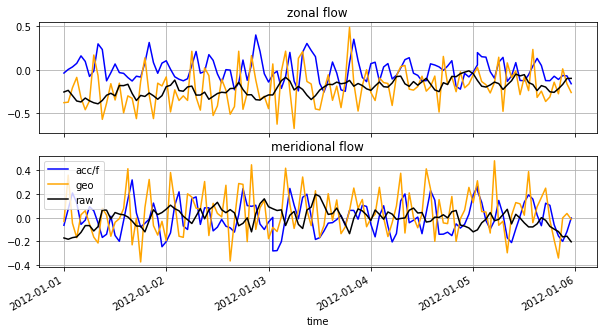

In [19]:

_df = _df.loc["2012-01-01":"2012-01-5"]

fig, axes = plt.subplots(2,1, figsize=(10,5))

ax = axes[0]
(_df["meridional_acceleration"]/_df["f"]).plot(ax=ax, color="b", label="acc/f")
#_df["zonal_geo_acc"].plot(ax=ax, color="b", label="geo+acc")
_df["zonal_velocity_geo"].plot(ax=ax, color="orange", label="geo")
_df["zonal_velocity"].plot(ax=ax, color="k", label="raw")
ax.set_xticklabels([])
ax.set_xlabel("")
ax.grid()
ax.set_title("zonal flow")

ax = axes[1]
(-_df["zonal_acceleration"]/_df["f"]).plot(ax=ax, color="b", label="acc/f")
#_df["meridional_geo_acc"].plot(ax=ax, color="b", label="geo+acc")
_df["meridional_velocity_geo"].plot(ax=ax, color="orange", label="geo")
_df["meridional_velocity"].plot(ax=ax, color="k", label="raw")
ax.grid()
ax.legend()
ax.set_title("meridional flow")

Text(0.5, 1.0, 'meridional flow')

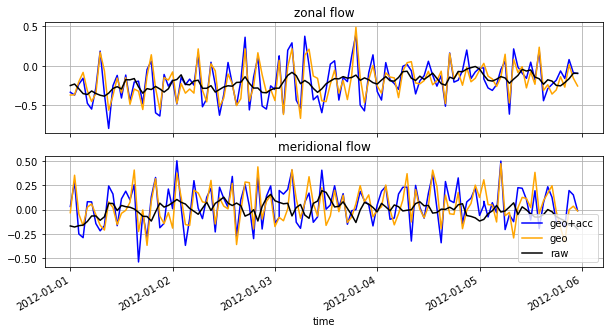

In [20]:
fig, axes = plt.subplots(2,1, figsize=(10,5))

ax = axes[0]
_df["zonal_geo_acc"].plot(ax=ax, color="b", label="geo+acc")
_df["zonal_velocity_geo"].plot(ax=ax, color="orange", label="geo")
_df["zonal_velocity"].plot(ax=ax, color="k", label="raw")
ax.set_xticklabels([])
ax.set_xlabel("")
ax.grid()
ax.set_title("zonal flow")

ax = axes[1]
_df["meridional_geo_acc"].plot(ax=ax, color="b", label="geo+acc")
_df["meridional_velocity_geo"].plot(ax=ax, color="orange", label="geo")
_df["meridional_velocity"].plot(ax=ax, color="k", label="raw")
ax.grid()
ax.legend()
ax.set_title("meridional flow")

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter( df["zonal_velocity"], df["zonal_velocity_geo"], s=.5)
ax.grid()

### go back to eulerian data to double check

In [4]:
#2012-01-01 00:00:00	37001319	34.286722	-123.387298

lon = -123.387298
lat = 34.286722
ijface = ut.find_ijface(lon, lat, radius=5)
ijface

{'i': slice(3134, 3140, None),
 'j': slice(219, 224, None),
 'face': slice(10, 11, None),
 'i_g': slice(3134, 3140, None),
 'j_g': slice(219, 224, None)}

In [5]:
import xgcm
import mitequinox.dynamic as dyn

In [6]:
ds = ut.load_data(["Eta", "SSU", "SSV"]).isel(**ijface)
ds = ds.sel(time=slice("2012-01-01 00:00:00","2012-01-30 00:00:00"))

grd = ut.load_grd().isel(**ijface)
ds = xr.merge([ds, grd]).chunk(dict(time=-1)).persist()

grid = xgcm.Grid(grd, periodic=['X', 'Y'])

# add coriolis parameters to dataset
#omega = 7.3/100000 # XY, 
# see, http://mitgcm.org/public/r2_manual/final/code_reference/vdb/names/R.htm
f = ut.coriolis(ds['YG'], signed=True) # at vorticity points
f_i = grid.interp(f,'X') # at v points
f_j = grid.interp(f,'Y') # at u points
ds = ds.assign_coords(f=f,f_i=f_i,f_j=f_j)

ds

<xarray.Dataset>
Dimensions:  (face: 1, i: 6, i_g: 6, j: 5, j_g: 5, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 697)
Coordinates: (12/37)
  * time     (time) datetime64[ns] 2012-01-01 2012-01-01T01:00:00 ... 2012-01-30
  * face     (face) int64 10
  * i        (i) int64 3134 3135 3136 3137 3138 3139
  * j        (j) int64 219 220 221 222 223
    niter    (time) int64 dask.array<chunksize=(697,), meta=np.ndarray>
  * i_g      (i_g) int64 3134 3135 3136 3137 3138 3139
    ...       ...
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 5, 6), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 5, 6), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 5, 6), meta=np.ndarray>
    f        (face, j_g, i_g) float32 dask.array<chunksize=(1, 5, 6), meta=np.ndarray>
    f_i      (face, j_g, i) float32 dask.array<chunksize=(1, 5, 5), meta=np.ndarray>
    f_j      (face, j, i_g) float32 dask.array<chunksize=(1, 4, 6), meta=np.ndarray>
Data variables:
    Eta      (time, face, j, i) float32 dask.array<chunksize=(697, 1, 5, 6), meta=np.ndarray>
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(697, 1, 5, 6), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(697, 1, 5, 6), meta=np.ndarray>

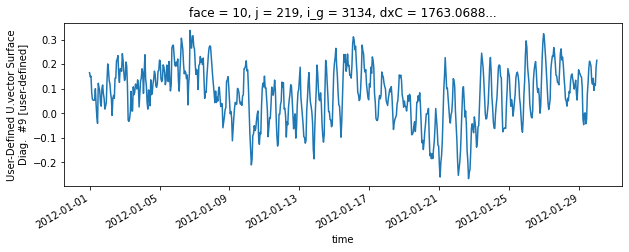

In [7]:
fig, ax = plt.subplots(figsize=(10,3))
ds.SSU.isel(i_g=0, j=0).plot()

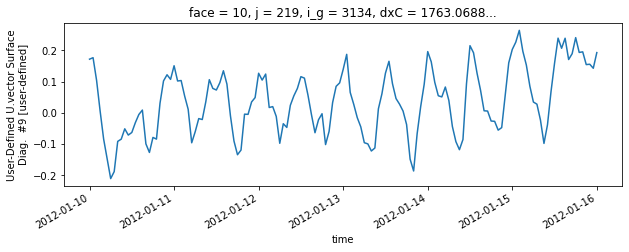

In [8]:
fig, ax = plt.subplots(figsize=(10,3))

_ds = ds.sel(time=slice("2012-01-01 00:00:00","2012-01-06 00:00:00"))
_ds = ds.sel(time=slice("2012-01-10 00:00:00","2012-01-16 00:00:00"))
_ds.SSU.isel(i_g=0, j=0).plot()

In [9]:
terms = ["u_coriolis_linear", "u_gradp", "u_acc", "v_coriolis_linear", "v_gradp", "v_acc"]

mbal = xr.merge([dyn.get_mbal(t, ds, grid) for t in terms])
ds = xr.merge([ds, mbal]).persist()

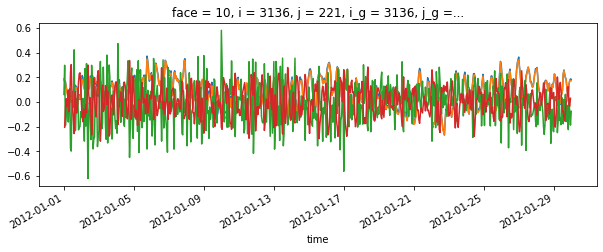

In [10]:

fig, ax = plt.subplots(figsize=(10,3))

_ds = ds.isel(i=2, i_g=2, j=2, j_g=2)

_ds.SSU.plot()
(-_ds.v_coriolis_linear/_ds.f_i).plot()
(_ds.v_gradp/_ds.f_i).plot()
(_ds.v_acc/_ds.f_i).plot()


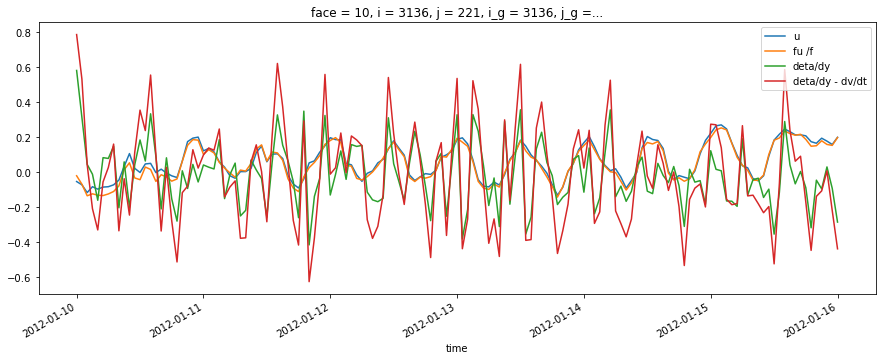

In [19]:

fig, ax = plt.subplots(figsize=(15,5))

_ds = ds.isel(i=2, i_g=2, j=2, j_g=2)
_ds = _ds.sel(time=slice("2012-01-10 00:00:00","2012-01-16 00:00:00"))

_ds.SSU.plot(label="u")
(-_ds.v_coriolis_linear/_ds.f_i).plot(label="fu /f")
(_ds.v_gradp/_ds.f_i).plot(label="deta/dy")
#(-_ds.v_acc/_ds.f_i).plot(label="-dvdt")
(_ds.v_gradp/_ds.f_i - _ds.v_acc/_ds.f_i).plot(label="deta/dy - dv/dt")

ax.legend()

### averaged statistics

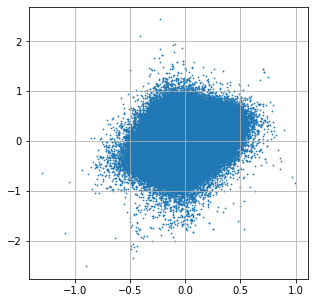

In [8]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter( df["zonal_velocity"], df["zonal_velocity_geo"], s=.5)
ax.grid()

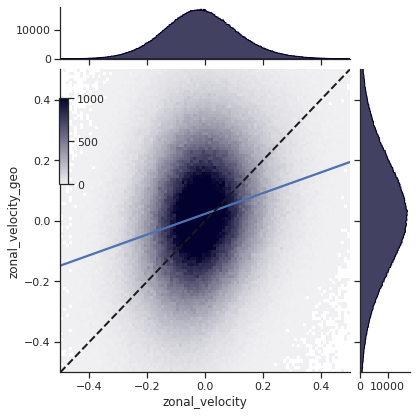

In [9]:
import seaborn as sns
sns.set_theme(style="ticks")

lims = (-.5, .5)

_data = dict(data=df, x="zonal_velocity", y="zonal_velocity_geo")

_g = sns.JointGrid(**_data,
                  marginal_ticks=True,
                  xlim=lims, ylim=lims,
                 )

# Create an inset legend for the histogram colorbar
cax = _g.fig.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
_g.plot_joint(
    sns.histplot, 
    binwidth = (.01, .01),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
sns.regplot(**_data, ax=_g.ax_joint, scatter=False)
_g.ax_joint.plot(lims, lims, color="k", ls="--", linewidth=2)

_g.plot_marginals(sns.histplot, element="step", color="#03012d")

Check amplitude of dEta_dy

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def get_proj(extent):
    lon = (extent[0]+extent[1])*.5
    lat = (extent[2]+extent[3])*.5
    return ccrs.Orthographic(central_longitude=lon, 
                     central_latitude=lat, 
                     globe=None,
                    )

extent = [-128, -123, 33, 38]
projection = get_proj(extent)

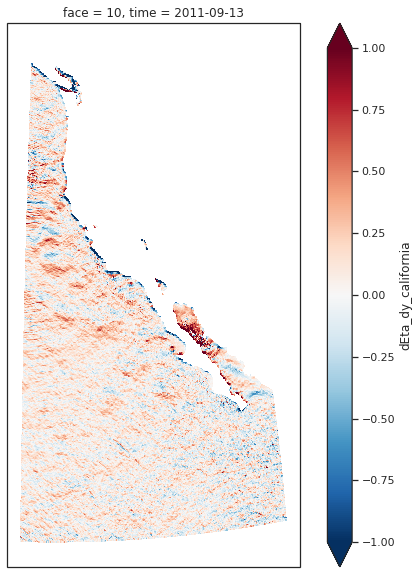

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=projection))

_ds = xr.open_zarr(os.path.join(ut.diag_dir,"dEta_dy_california.zarr")).isel(time=0)

(-g*_ds["dEta_dy_california"]/f.mean()).plot(ax=ax, x="XC", y="YC", vmin=-1, vmax=1, cmap="RdBu_r", transform=ccrs.PlateCarree(),)

---

### low pass filtering

In [48]:
from scipy import signal
import mitequinox.sigp as sp

### generate filter

In [49]:
dt = 1/24 # in days
T=10 # filter length in days

h = sp.generate_filter("subdiurnal", T=T, dt=dt)
h_hat, w = sp.filter_response(h, dt=dt)

No handles with labels found to put in legend.


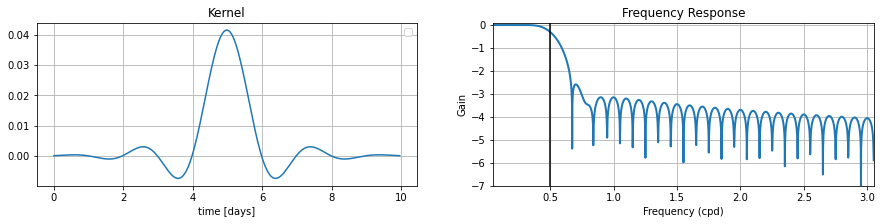

In [50]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
t = np.arange(0, h.size)*dt
ax.plot(t, h)
ax.grid()
ax.set_xlabel("time [days]")
ax.set_title("Kernel")
ax.legend()

ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(0.5, color="k")
ax.set_xlabel("Frequency (cpd)")
ax.set_ylabel("Gain")
ax.set_title("Frequency Response")
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

### apply filter to drifter data

In [55]:
def filter_data(x, h, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    # fill blanks in time series with NaN
    x = x.resample("1H").mean()
    if x.index.size<3*h.size:
        return x*np.NaN
    
    if hilbert:
        f = lambda x: signal.hilbert(signal.filtfilt(h, [1], x))
    else:
        f = lambda x: signal.filtfilt(h, [1], x)
    return x.apply(f, axis=0)

df_low = df.groupby("trajectory").apply(filter_data, h)

### focus on indiviual trajectories

In [56]:
bbox = [-126, -125, 35, 36]
_df = df[ (df["lon"]>bbox[0]) & (df["lon"]<bbox[1]) & (df["lat"]>bbox[2]) & (df["lat"]<bbox[3]) ]
traj = _df["trajectory"].unique()
df_box = df_low[ df_low["trajectory"].isin(traj) ]
df_box.head()

trajectory        lat         lon    z  \
trajectory time                                                          
37000994   2012-04-04 16:00:00  37000994.0  37.642652 -128.006312  0.0   
           2012-04-04 17:00:00  37000994.0  37.633228 -127.997587  0.0   
           2012-04-04 18:00:00  37000994.0  37.623809 -127.988874  0.0   
           2012-04-04 19:00:00  37000994.0  37.614400 -127.980182  0.0   
           2012-04-04 20:00:00  37000994.0  37.605005 -127.971521  0.0   

                                zonal_velocity  meridional_velocity  \
trajectory time                                                       
37000994   2012-04-04 16:00:00        0.248981            -0.063980   
           2012-04-04 17:00:00        0.244187            -0.079533   
           2012-04-04 18:00:00        0.239404            -0.095002   
           2012-04-04 19:00:00        0.234640            -0.110303   
           2012-04-04 20:00:00        0.229905            -0.125354   

                                sea_level  temperature   salinity  \
trajectory time                                                     
37000994   2012-04-04 16:00:00   0.607316    11.130877  32.888382   
           2012-04-04 17:00:00   0.578968    11.136235  32.888454   
           2012-04-04 18:00:00   0.550756    11.141610  32.888531   
           2012-04-04 19:00:00   0.522818    11.147022  32.888614   
           2012-04-04 20:00:00   0.495284    11.152487  32.888709   

                                sea_level_mean  zonal_velocity_mean  \
trajectory time                                                       
37000994   2012-04-04 16:00:00        0.342872            -0.001139   
           2012-04-04 17:00:00        0.342760            -0.002673   
           2012-04-04 18:00:00        0.342648            -0.004205   
           2012-04-04 19:00:00        0.342532            -0.005735   
           2012-04-04 20:00:00        0.342411            -0.007259   

                                temperature_mean  meridional_velocity_mean  \
trajectory time                                                              
37000994   2012-04-04 16:00:00         14.076355                 -0.061955   
           2012-04-04 17:00:00         14.075066                 -0.063482   
           2012-04-04 18:00:00         14.073777                 -0.065008   
           2012-04-04 19:00:00         14.072490                 -0.066530   
           2012-04-04 20:00:00         14.071205                 -0.068047   

                                salinity_mean   dEta_dx       dEta_dy  \
trajectory time                                                         
37000994   2012-04-04 16:00:00      33.009215  0.002242  2.991744e-07   
           2012-04-04 17:00:00      33.008458  0.002071 -1.071456e-06   
           2012-04-04 18:00:00      33.007702  0.001902 -2.433933e-06   
           2012-04-04 19:00:00      33.006950  0.001734 -3.780182e-06   
           2012-04-04 20:00:00      33.006201  0.001569 -5.102289e-06   

                                zonal_velocity_geo  meridional_velocity_geo  
trajectory time                                                              
37000994   2012-04-04 16:00:00           -0.003359                25.165346  
           2012-04-04 17:00:00            0.012075                23.252681  
           2012-04-04 18:00:00            0.027417                21.349596  
           2012-04-04 19:00:00            0.042576                19.465581  
           2012-04-04 20:00:00            0.057465                17.609943

Text(0.5, 1.0, 'meridional flow')

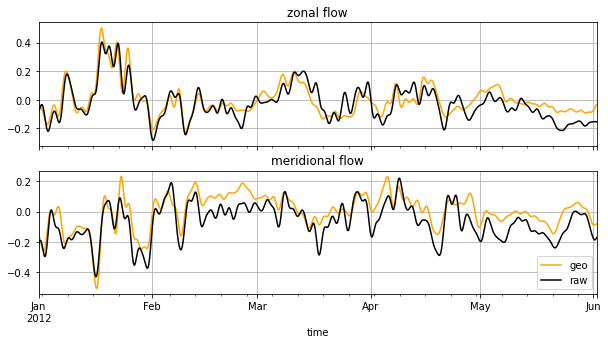

In [64]:
_df = df_box.loc[ traj[0] ]
_df = _df.loc["2012-01-01":"2012-06-01"] # hides the end of the time series where there is a spike of unknown origin

fig, axes = plt.subplots(2,1, figsize=(10,5))

ax = axes[0]
_df["zonal_velocity_geo"].plot(ax=ax, color="orange", label="geo")
_df["zonal_velocity"].plot(ax=ax, color="k", label="raw")
ax.set_xticklabels([])
ax.set_xlabel("")
ax.grid()
ax.set_title("zonal flow")

ax = axes[1]
_df["meridional_velocity_geo"].plot(ax=ax, color="orange", label="geo")
_df["meridional_velocity"].plot(ax=ax, color="k", label="raw")
ax.grid()
ax.legend()
ax.set_title("meridional flow")

### average statistics

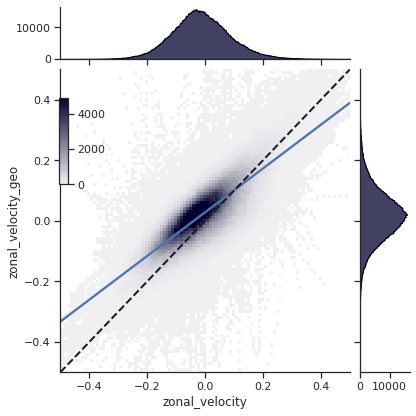

In [74]:
import seaborn as sns
sns.set_theme(style="ticks")

lims = (-.5, .5)

_data = dict(data=df_low, x="zonal_velocity", y="zonal_velocity_geo")

_g = sns.JointGrid(**_data,
                  marginal_ticks=True,
                  xlim=lims, ylim=lims,
                 )

# Create an inset legend for the histogram colorbar
cax = _g.fig.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
_g.plot_joint(
    sns.histplot, 
    binwidth = (.01, .01),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
sns.regplot(**_data, ax=_g.ax_joint, scatter=False)
_g.ax_joint.plot(lims, lims, color="k", ls="--", linewidth=2)

_g.plot_marginals(sns.histplot, element="step", color="#03012d")

---

In [20]:
cluster.close()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when 